# Ridge and Lasso Regression Models

In [474]:
import os
import sys

sys.dont_write_bytecode = True

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from sklearn.model_selection import train_test_split

from dotenv import load_dotenv
load_dotenv()
current_dir = os.getcwd()
prod_dir = os.path.abspath(os.path.join(current_dir, "..", "..", "Prod"))
sys.path.append(prod_dir)

from etl import FrequencyEncoder, CircleOfFifthsEncoding, ConvertNull


In [475]:
DATA_DIR = './Data/'
DATA_FILE = 'spotify_tracks_kaggle_weekly.csv'



In [476]:
data = pd.read_csv(DATA_DIR + DATA_FILE)

Data splitting -> working with predefined $X_{train}$

In [477]:
RANDOM_STATE = 21
TEST_SIZE = 0.1

In [478]:
X = data.drop('popularity', axis=1)
y = data['popularity']

In [479]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

Dropping columns defined in EDA

In [480]:
drop_columns = ['track_id', 'artwork_url', 'track_url', 'track_name', 'album_name']

In [481]:
X_train = X_train.drop(drop_columns, axis=1, errors='ignore')
X_test = X_test.drop(drop_columns, axis=1, errors='ignore')

transformation pipeline

In [482]:
target = 'popularity'

onehot_col = ['language']
circle_of_fifths_col = ['key']
artist_name_col = ['artist_name']

numeric_columns = list(X_train.columns[X_train.dtypes != object].difference(['key', 'mode']))

nan_columns = ['acousticness', 'danceability', 'energy', 'liveness', 'speechiness', 'tempo', 'valence']

In [483]:
numeric_pipeline = Pipeline(steps=[
    ('scaling', RobustScaler())
])

artist_name_pipeline = Pipeline(steps=[
    ('encoding', FrequencyEncoder()),
    ('scaling', StandardScaler())
])


transformations = ColumnTransformer(transformers=[
    
    ('onehot_encoding', OneHotEncoder(sparse_output=False), onehot_col),
    ('trigonometric_encoding', CircleOfFifthsEncoding(), circle_of_fifths_col),
    ('artist_encoding', artist_name_pipeline, artist_name_col),
    ('nummeric_processing', numeric_pipeline, numeric_columns)

], remainder='drop')


preprocessing = Pipeline(steps=[
    ('null_values', ConvertNull(columns=nan_columns)),
    ('transformation', transformations)
])

transformation of data

In [484]:
X_train_transformed = preprocessing.fit_transform(X_train)

onehot_columns = preprocessing.named_steps['transformation'].transformers_[0][1].get_feature_names_out(onehot_col)
circle_of_fifths_columns = ['key_x', 'key_y']  
artist_name_columns = ['artist_name_encoded']  
numeric_columns = numeric_columns  

all_columns = list(onehot_columns) + circle_of_fifths_columns + artist_name_columns + numeric_columns

X_train = pd.DataFrame(X_train_transformed, columns=all_columns)

y_train = y_train.reset_index(drop=True)

In [485]:
# # remove Null values
X_train = X_train.dropna()
y_train = y_train[X_train.index]


**RIDGE**

In [486]:
X_test_transformed = preprocessing.transform(X_test)

X_test = pd.DataFrame(X_test_transformed, columns=all_columns)

y_test = y_test.reset_index(drop=True)

# # remove Null values
X_test = X_test.dropna()
y_test = y_test[X_test.index]

In [487]:
ridge = Ridge()
ridge.fit(X_train, y_train)

Ridge()

In [488]:
y_pred = ridge.predict(X_test)

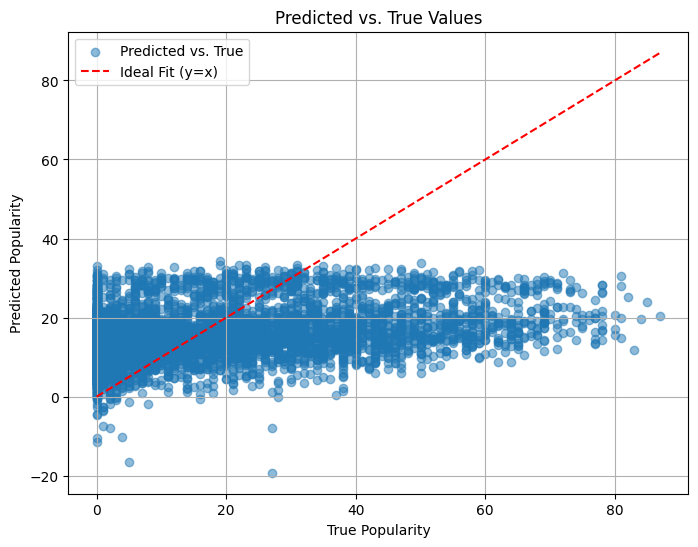

In [489]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label='Predicted vs. True')

plt.xlabel('True Popularity')
plt.ylabel('Predicted Popularity')
plt.title('Predicted vs. True Values')

# perfect fit line
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='Ideal Fit (y=x)')
plt.legend()
plt.grid()
plt.show()

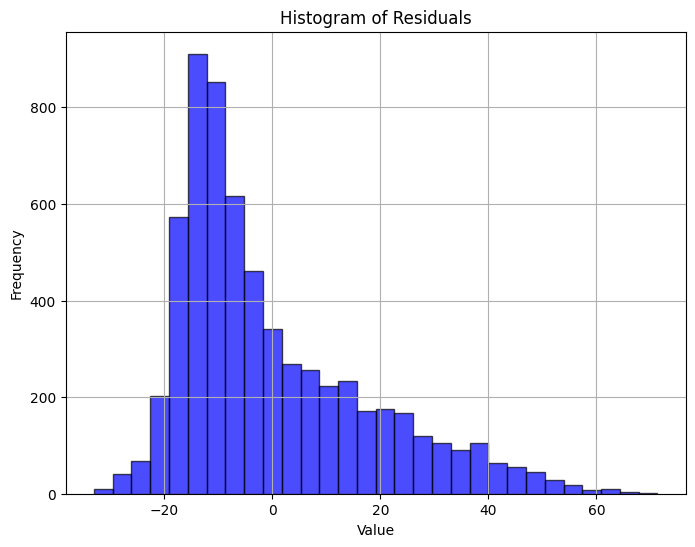

In [490]:
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.grid()
plt.show()

Text(0.5, 1.0, 'Feature Importance')

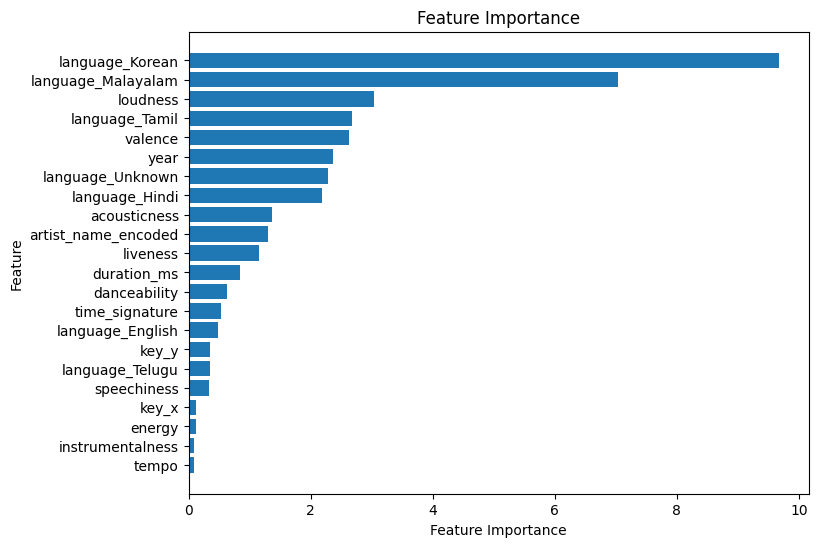

In [491]:
importance = np.abs(ridge.coef_)
features = X_train.columns
importance, features = zip(*sorted(zip(importance, features)))

plt.figure(figsize=(8, 6))
plt.barh(range(len(features)), importance, align='center')
plt.yticks(range(len(features)), features)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')

# Lasso regression

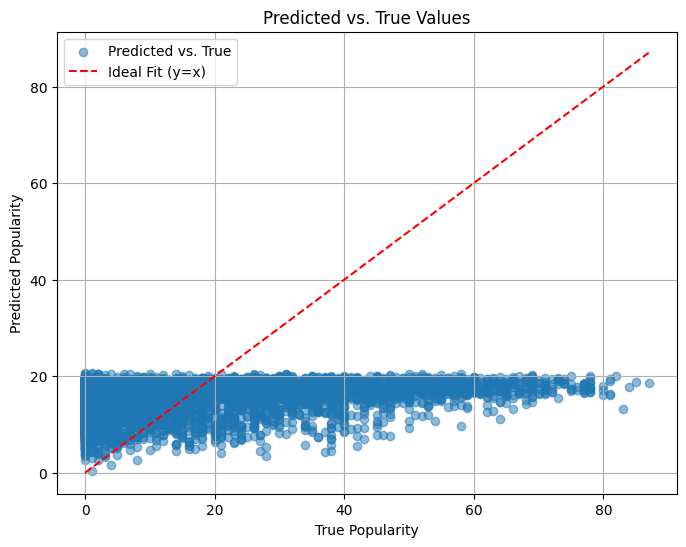

In [492]:
lasso = Lasso()
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label='Predicted vs. True')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='Ideal Fit (y=x)')
plt.xlabel('True Popularity')
plt.ylabel('Predicted Popularity')
plt.title('Predicted vs. True Values')
plt.legend()
plt.grid()
plt.show()

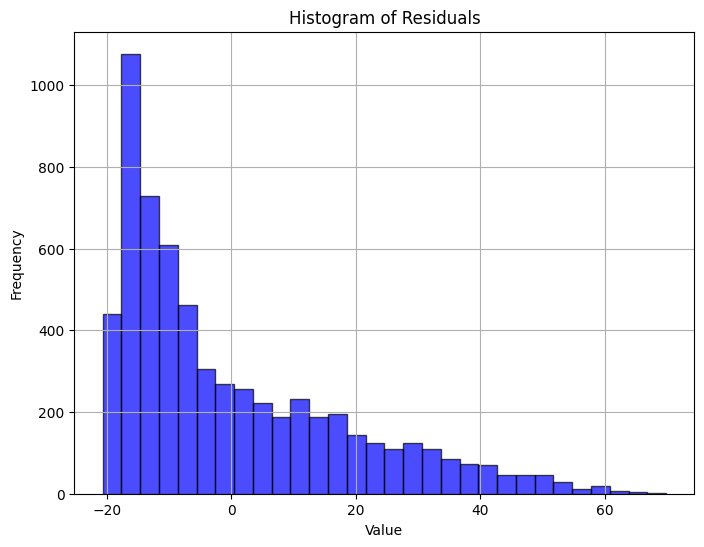

In [493]:
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.grid()
plt.show()

Text(0.5, 1.0, 'Feature Importance')

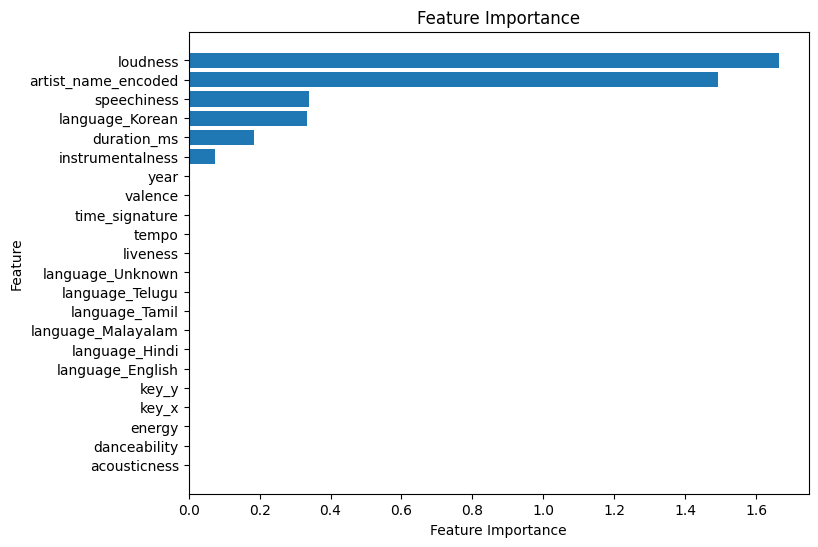

In [494]:
importance = np.abs(lasso.coef_)
features = X_train.columns
importance, features = zip(*sorted(zip(importance, features)))

plt.figure(figsize=(8, 6))
plt.barh(range(len(features)), importance, align='center')
plt.yticks(range(len(features)), features)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')


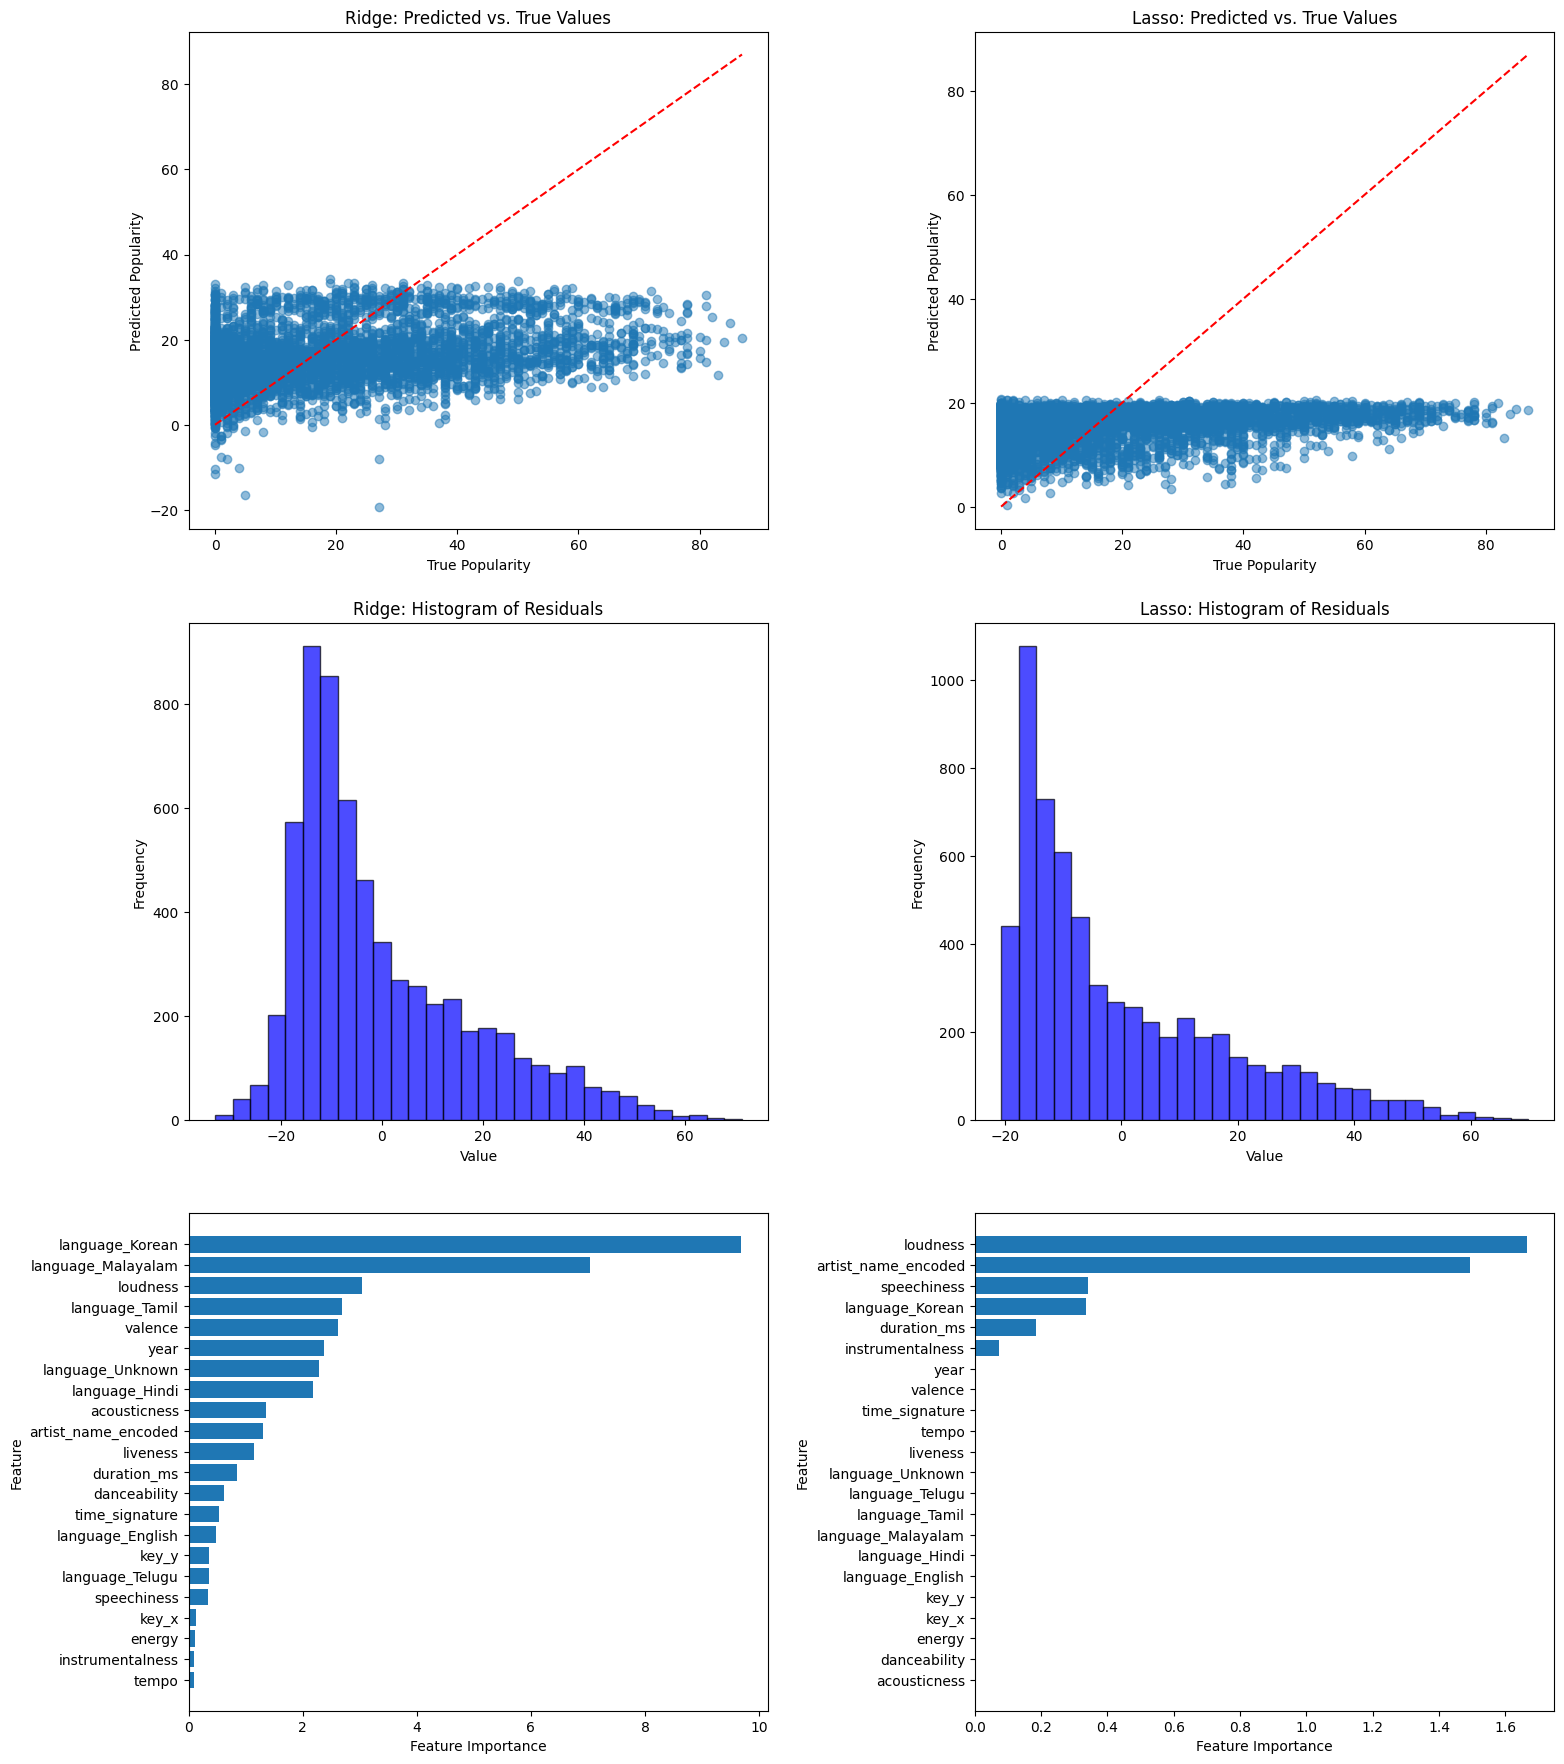

In [495]:
# plot pred vs true, residuals, feature imporatnce for ridge and lasso next to each other 3*2 grid


ridge = Ridge()
lasso = Lasso()

ridge.fit(X_train, y_train)
lasso.fit(X_train, y_train)

y_pred_ridge = ridge.predict(X_test)
y_pred_lasso = lasso.predict(X_test)

fig, axs = plt.subplots(3, 2, figsize=(16, 18))

axs[0, 0].scatter(y_test, y_pred_ridge, alpha=0.5, label='Predicted vs. True')
axs[0, 0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='Ideal Fit ')
axs[0, 0].set_xlabel('True Popularity')
axs[0, 0].set_ylabel('Predicted Popularity')
axs[0, 0].set_title('Ridge: Predicted vs. True Values')

axs[0, 1].scatter(y_test, y_pred_lasso, alpha=0.5, label='Predicted vs. True')
axs[0, 1].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='Ideal Fit ')
axs[0, 1].set_xlabel('True Popularity')
axs[0, 1].set_ylabel('Predicted Popularity')
axs[0, 1].set_title('Lasso: Predicted vs. True Values')

residuals_ridge = y_test - y_pred_ridge
residuals_lasso = y_test - y_pred_lasso

axs[1, 0].hist(residuals_ridge, bins=30, alpha=0.7, color='blue', edgecolor='black')
axs[1, 0].set_xlabel('Value')
axs[1, 0].set_ylabel('Frequency')
axs[1, 0].set_title('Ridge: Histogram of Residuals')

axs[1, 1].hist(residuals_lasso, bins=30, alpha=0.7, color='blue', edgecolor='black')
axs[1, 1].set_xlabel('Value')
axs[1, 1].set_ylabel('Frequency')
axs[1, 1].set_title('Lasso: Histogram of Residuals')

importance_ridge = np.abs(ridge.coef_)
features_ridge = X_train.columns
importance_ridge, features_ridge = zip(*sorted(zip(importance_ridge, features_ridge)))

importance_lasso = np.abs(lasso.coef_)
features_lasso = X_train.columns
importance_lasso, features_lasso = zip(*sorted(zip(importance_lasso, features_lasso)))

axs[2, 0].barh(range(len(features_ridge)), importance_ridge, align='center')
axs[2, 0].set_yticks(range(len(features_ridge)))
axs[2, 0].set_yticklabels(features_ridge)
axs[2, 0].set_xlabel('Feature Importance')
axs[2, 0].set_ylabel('Feature')

axs[2, 1].barh(range(len(features_lasso)), importance_lasso, align='center')
axs[2, 1].set_yticks(range(len(features_lasso)))
axs[2, 1].set_yticklabels(features_lasso)
axs[2, 1].set_xlabel('Feature Importance')
axs[2, 1].set_ylabel('Feature')

# gap between columns of graphs larger
plt.tight_layout(pad=2.0)